# Similarity and Distance Measures

```yaml
Course:   DS 5001
Module:   06 6 Lab
Topic:    Similarity and Distance Measures
Author:   R.C.Alvarado
Date:     19 February 2023 (revised)
```

# Set Up

## Config

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_hone = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']

In [2]:
data_prefix = 'austen-melville'
OHCO = ['book_id', 'chap_id']
bag = 'CHAPS'
colors = "YlGnBu"
tf_agg = 'sum'

## Import

In [3]:
import pandas as pd
import numpy as np

In [4]:
import plotly_express as px
import seaborn as sns; sns.set()

In [5]:
from numpy.linalg import norm
from scipy.spatial.distance import pdist

In [7]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Prepare the Data

## Import tables

In [9]:
BOW = pd.read_csv(f"{output_dir}/{data_prefix}-BOW-{bag}.csv").set_index(OHCO+['term_str'])
LIB = pd.read_csv(f'{output_dir}/{data_prefix}-LIB.csv').set_index('book_id')

In [10]:
LIB

source_file_path            author  \
book_id                                                                        
105      /home/cwp5xyj/Documents/MSDS/DS5001/data/auste...      AUSTEN, JANE   
121      /home/cwp5xyj/Documents/MSDS/DS5001/data/auste...      AUSTEN, JANE   
141      /home/cwp5xyj/Documents/MSDS/DS5001/data/auste...      AUSTEN, JANE   
158      /home/cwp5xyj/Documents/MSDS/DS5001/data/auste...      AUSTEN, JANE   
161      /home/cwp5xyj/Documents/MSDS/DS5001/data/auste...      AUSTEN, JANE   
946      /home/cwp5xyj/Documents/MSDS/DS5001/data/auste...      AUSTEN, JANE   
1212     /home/cwp5xyj/Documents/MSDS/DS5001/data/auste...      AUSTEN, JANE   
1342     /home/cwp5xyj/Documents/MSDS/DS5001/data/auste...      AUSTEN, JANE   
1900     /home/cwp5xyj/Documents/MSDS/DS5001/data/auste...  MELVILLE, HERMAN   
2701     /home/cwp5xyj/Documents/MSDS/DS5001/data/auste...  MELVILLE, HERMAN   
4045     /home/cwp5xyj/Documents/MSDS/DS5001/data/auste...  MELVILLE, HERMAN   
8118     /home/cwp5xyj/Documents/MSDS/DS5001/data/auste...  MELVILLE, HERMAN   
10712    /home/cwp5xyj/Documents/MSDS/DS5001/data/auste...  MELVILLE, HERMAN   
13720    /home/cwp5xyj/Documents/MSDS/DS5001/data/auste...  MELVILLE, HERMAN   
13721    /home/cwp5xyj/Documents/MSDS/DS5001/data/auste...  MELVILLE, HERMAN   
15422    /home/cwp5xyj/Documents/MSDS/DS5001/data/auste...  MELVILLE, HERMAN   
15859    /home/cwp5xyj/Documents/MSDS/DS5001/data/auste...  MELVILLE, HERMAN   
21816    /home/cwp5xyj/Documents/MSDS/DS5001/data/auste...  MELVILLE, HERMAN   
34970    /home/cwp5xyj/Documents/MSDS/DS5001/data/auste...  MELVILLE, HERMAN   

                                                     title  \
book_id                                                      
105                                             PERSUASION   
121                                       NORTHANGER ABBEY   
141                                         MANSFIELD PARK   
158                                                   EMMA   
161                                  SENSE AND SENSIBILITY   
946                                             LADY SUSAN   
1212                               LOVE AND FREINDSHIP SIC   
1342                                   PRIDE AND PREJUDICE   
1900                     TYPEE A ROMANCE OF THE SOUTH SEAS   
2701                                MOBY DICK OR THE WHALE   
4045                     OMOO ADVENTURES IN THE SOUTH SEAS   
8118     REDBURN HIS FIRST VOYAGE BEING THE SAILOR BOY ...   
10712            WHITE JACKET OR THE WORLD ON A MAN OF WAR   
13720                     MARDI AND A VOYAGE THITHER VOL I   
13721                    MARDI AND A VOYAGE THITHER VOL II   
15422               ISRAEL POTTER HIS FIFTY YEARS OF EXILE   
15859                                     THE PIAZZA TALES   
21816                    THE CONFIDENCE MAN HIS MASQUERADE   
34970                            PIERRE OR THE AMBIGUITIES   

                              chap_regex  book_len  n_chaps  
book_id                                                      
105                      ^Chapter\s+\d+$     83624       24  
121                      ^CHAPTER\s+\d+$     77601       31  
141                ^CHAPTER\s+[IVXLCM]+$    160378       48  
158          ^\s*CHAPTER\s+[IVXLCM]+\s*$    160926       55  
161                      ^CHAPTER\s+\d+$    119873       50  
946                    ^\s*[IVXLCM]+\s*$     23116       41  
1212                ^\s*LETTER .* to .*$     33265       24  
1342                     ^Chapter\s+\d+$    122126       61  
1900                           ^CHAPTER     108021       34  
2701     ^(?:ETYMOLOGY|EXTRACTS|CHAPTER)    215504      138  
4045       ^\s*CHAPTER\s+[IVXLCM]+\.\s*$    102352       82  
8118                 ^\s*[IVXLCM]+\. .*$    119243       78  
10712         ^CHAPTER\s+[IVXLCM]+\.\s*$    143310       92  
13720        ^\s*CHAPTER\s+[IVXLCM]+\s*$     96878      104  
13721        ^\s*CHAPTER\s+[IVXLCM]+\s*$    102092       91  
1542

In [11]:
BOW

n     tfidf
book_id chap_id term_str                   
105     1       able          1.0  0.011987
                abroad        1.0  0.016259
                acknowledged  1.0  0.017843
                acquaintance  4.0  0.050617
                added         2.0  0.022707
...                           ...       ...
34970   114     ye            1.0  0.041773
                yes           2.0  0.067853
                yes yes       1.0  0.068079
                young         2.0  0.056646
                young lady    1.0  0.060621

[387061 rows x 2 columns]

Add label for visualizations

In [12]:
LIB['label'] = LIB.author.str.split(', ').str[0] + ': ' +  LIB.title.str[:20] + ' (' + LIB.index.astype('str') + ')'
LIB['label'] = LIB.label.str.title()

In [13]:
LIB.label

book_id
105                    Austen: Persuasion (105)
121              Austen: Northanger Abbey (121)
141                Austen: Mansfield Park (141)
158                          Austen: Emma (158)
161          Austen: Sense And Sensibilit (161)
946                    Austen: Lady Susan (946)
1212        Austen: Love And Freindship  (1212)
1342         Austen: Pride And Prejudice (1342)
1900      Melville: Typee A Romance Of T (1900)
2701      Melville: Moby Dick Or The Wha (2701)
4045      Melville: Omoo Adventures In T (4045)
8118      Melville: Redburn His First Vo (8118)
10712    Melville: White Jacket Or The  (10712)
13720    Melville: Mardi And A Voyage T (13720)
13721    Melville: Mardi And A Voyage T (13721)
15422    Melville: Israel Potter His Fi (15422)
15859        Melville: The Piazza Tales (15859)
21816    Melville: The Confidence Man H (21816)
34970    Melville: Pierre Or The Ambigu (34970)
Name: label, dtype: object

## Generate TFIDF Matrix

Even though we already computed TFIDF in our imported BOW, we recreate it here.

In [14]:
get_tfidf = lambda X, agg_func='sum': (X.T / X.T.agg(agg_func)).T * (np.log2(len(X)/X.astype('bool').sum()))

In [15]:
TFIDF_CHAP = get_tfidf(BOW.n.unstack(fill_value=0), tf_agg)

In [16]:
TFIDF_CHAP

term_str              NaN  abandoned  abbey      able  aboard    abode  \
book_id chap_id                                                          
105     1        0.000000   0.000000    0.0  0.002500     0.0  0.00000   
        2        0.000000   0.000000    0.0  0.003230     0.0  0.00673   
        3        0.003421   0.000000    0.0  0.000000     0.0  0.00000   
        4        0.000000   0.000000    0.0  0.000000     0.0  0.00000   
        5        0.000000   0.000000    0.0  0.003911     0.0  0.00000   
...                   ...        ...    ...       ...     ...      ...   
34970   110      0.000000   0.018628    0.0  0.000000     0.0  0.00000   
        111      0.000000   0.000000    0.0  0.000000     0.0  0.00000   
        112      0.000000   0.000000    0.0  0.000000     0.0  0.00000   
        113      0.000000   0.000000    0.0  0.000000     0.0  0.00000   
        114      0.000000   0.000000    0.0  0.000000     0.0  0.00000   

term_str         abrazza    abroad   absence  absent  ...  young ladies  \
book_id chap_id                                       ...                 
105     1            0.0  0.003987  0.000000     0.0  ...      0.000000   
        2            0.0  0.000000  0.000000     0.0  ...      0.000000   
        3            0.0  0.007135  0.000000     0.0  ...      0.000000   
        4            0.0  0.000000  0.000000     0.0  ...      0.000000   
        5            0.0  0.003119  0.005552     0.0  ...      0.006843   
...                  ...       ...       ...     ...  ...           ...   
34970   110          0.0  0.000000  0.000000     0.0  ...      0.000000   
        111          0.0  0.000000  0.009839     0.0  ...      0.000000   
        112          0.0  0.000000  0.000000     0.0  ...      0.000000   
        113          0.0  0.000000  0.000000     0.0  ...      0.000000   
        114          0.0  0.000000  0.000000     0.0  ...      0.000000   

term_str         young lady  young man  young men  young people  young woman  \
book_id chap_id                                                                
105     1          0.000000   0.006446        0.0        0.0000     0.000000   
        2          0.000000   0.000000        0.0        0.0000     0.006567   
        3          0.000000   0.000000        0.0        0.0000     0.000000   
        4          0.000000   0.013954        0.0        0.0000     0.000000   
        5          0.000000   0.000000        0.0        0.0041     0.000000   
...                     ...        ...        ...           ...          ...   
34970   110        0.000000   0.000000        0.0        0.0000     0.000000   
        111        0.000000   0.000000        0.0        0.0000     0.000000   
        112        0.000000   0.000000        0.0        0.0000     0.000000   
        113        0.000000   0.000000        0.0        0.0000     0.000000   
        114        0.019161   0.000000        0.0        0.0000     0.000000   

term_str          younger  youngest     youth  youthful  
book_id chap_id                                          
105     1        0.004703  0.005944  0.010006  0.005311  
        2        0.000000  0.000000  0.000000  0.000000  
        3        0.000000  0.000000  0.005969  0.000000  
        4        0.006787  0.000000  0.014440  0.000000  
        5        0.000000  0.000000  0.000000  0.000000  
...                   ...       ...       ...       ...  
34970   110      0.000000  0.000000  0.000000  0.000000  
        111      0.000000  0.000000  0.000000  0.000000  
        112      0.000000  0.000000  0.000000  0.000000  
        113      0.000000  0.000000  0.000000  0.000000  
        114      0.000000  0.000000  0.000000  0.000000  

[1182 rows x 4000 columns]

## Collapse Bags

We want to work with larger bags in this notebook, in order to better visualize our resulting clusters.

Note that this is not the same as beginning with book as the bag! We are getting aggregate TFIDF for chapters.

In [17]:
TFIDF = TFIDF_CHAP.groupby(OHCO[:1]).mean()

In [18]:
TFIDF

term_str       NaN  abandoned     abbey      able    aboard     abode  \
book_id                                                                 
105       0.000826   0.000000  0.000000  0.002166  0.000000  0.000280   
121       0.000344   0.000000  0.007838  0.002843  0.000000  0.000306   
141       0.000727   0.000000  0.000144  0.002800  0.000000  0.000698   
158       0.000660   0.000000  0.002478  0.003230  0.000000  0.000099   
161       0.000218   0.000137  0.000000  0.002314  0.000000  0.000656   
946       0.000537   0.000000  0.000000  0.004072  0.000000  0.000000   
1212      0.021300   0.000522  0.000299  0.002883  0.000000  0.000000   
1342      0.000366   0.000000  0.000000  0.002723  0.000000  0.001086   
1900      0.009135   0.001562  0.000204  0.001150  0.001369  0.001115   
2701      0.000528   0.000466  0.000000  0.000205  0.001221  0.000088   
4045      0.000299   0.000636  0.000000  0.000301  0.005104  0.001047   
8118      0.000306   0.000419  0.000387  0.000627  0.001475  0.000000   
10712     0.002681   0.000401  0.000161  0.001102  0.000964  0.000000   
13720     0.000251   0.001197  0.000126  0.000037  0.000197  0.001461   
13721     0.000819   0.000511  0.000139  0.000135  0.000000  0.000554   
15422     0.000677   0.001414  0.000000  0.000405  0.000462  0.000618   
15859     0.000573   0.001333  0.000214  0.000094  0.000000  0.000390   
21816     0.000542   0.000118  0.000000  0.000177  0.011643  0.000000   
34970     0.000679   0.001004  0.000000  0.000190  0.000000  0.000000   

term_str  abrazza    abroad   absence    absent  ...  young ladies  \
book_id                                          ...                 
105       0.00000  0.000711  0.000771  0.000431  ...      0.000854   
121       0.00000  0.000739  0.002013  0.001244  ...      0.001808   
141       0.00000  0.000351  0.002081  0.001693  ...      0.000956   
158       0.00000  0.000411  0.001157  0.000709  ...      0.001420   
161       0.00000  0.000918  0.000919  0.000361  ...      0.001553   
946       0.00000  0.000000  0.001502  0.000000  ...      0.000000   
1212      0.00000  0.000000  0.001075  0.001376  ...      0.001119   
1342      0.00000  0.000298  0.002097  0.000238  ...      0.002492   
1900      0.00000  0.000114  0.000776  0.000689  ...      0.000591   
2701      0.00000  0.000281  0.000199  0.000669  ...      0.000000   
4045      0.00000  0.001141  0.000618  0.000091  ...      0.000619   
8118      0.00000  0.000074  0.000444  0.000236  ...      0.000062   
10712     0.00000  0.000449  0.000268  0.000519  ...      0.000000   
13720     0.00000  0.001675  0.001126  0.000715  ...      0.000000   
13721     0.00853  0.001984  0.000291  0.000808  ...      0.000000   
15422     0.00000  0.001088  0.000384  0.000469  ...      0.000000   
15859     0.00000  0.000149  0.000931  0.000820  ...      0.000000   
21816     0.00000  0.000138  0.000200  0.000155  ...      0.000000   
34970     0.00000  0.000862  0.000582  0.000524  ...      0.000366   

term_str  young lady  young man  young men  young people  young woman  \
book_id                                                                 
105         0.000606   0.002353   0.000475      0.001300     0.001088   
121         0.003823   0.003078   0.002567      0.001696     0.001082   
141         0.000838   0.001796   0.000826      0.002371     0.001108   
158         0.001186   0.004194   0.000126      0.000849     0.001835   
161         0.001008   0.001864   0.000991      0.000758     0.001063   
946         0.001435   0.004367   0.000789      0.000000     0.000000   
1212        0.000899   0.001870   0.002503      0.000571     0.000968   
1342        0.001667   0.002609   0.001351      0.000272     0.000882   
1900        0.000203   0.000274   0.002088      0.000180     0.000000   
2701        0.000000   0.000307   0.000049      0.000000     0.000000   
4045        0.000460   0.000377   0.000098      0.000000     0.000000   
8118        0.000108   0.001183   0.000501    

## Create Normalized Tables

We normalize TFIDF values in various ways. 

Normalizations types are required for certain distance measures.

In [19]:
L0 = TFIDF.astype('bool').astype('int') # Binary (Pseudo L)
L1 = TFIDF.apply(lambda x: x / x.sum(), 1) # Probabilistic
L2 = TFIDF.apply(lambda x: x / norm(x), 1) # Pythagorean, AKA Euclidean

## Visualize 

Pause and explore results.

We get a visual sense of what vector distance is.

In [20]:
sample_terms = "war peace love joy heart mind home ship whale england america island father sister man woman".split()

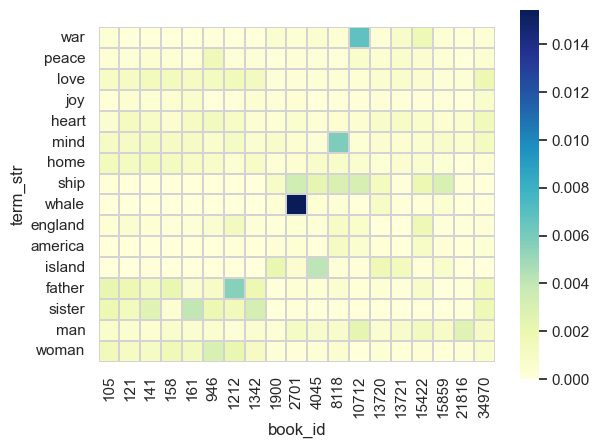

In [21]:
sns.heatmap(L1[sample_terms].T, cmap=colors, linewidth=.01, linecolor="lightgray", square=True);

## Create Doc Pair Table

Create a table to store our results.

Note that `pist()` is a "distance matrix computation from a collection of raw observation vectors stored in a rectangular array".

Note: We might also use [sklearn.metrics.DistanceMetric](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html#sklearn.metrics.DistanceMetric) and [sklearn.metrics.pairwise.cosine_distances](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html#sklearn.metrics.pairwise.cosine_distances)

In [22]:
# Create dataframe with cartesian product of books by books
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([LIB.index.tolist(), LIB.index.tolist()])).reset_index()

# Keep only unique pairs of different books
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])

# Name index cols
PAIRS.index.names = ['doc_a', 'doc_b']

In [23]:
PAIRS.shape

(171, 0)

In [24]:
PAIRS.head()

Empty DataFrame
Columns: []
Index: [(105, 121), (105, 141), (105, 158), (105, 161), (105, 946)]

## Compute Distances

Now we use `pdist()` to compute a bunch of pairwise distances.

We associate measure types with the right norms.

In [25]:
PAIRS['cityblock'] = pdist(TFIDF, 'cityblock')
PAIRS['euclidean'] = pdist(TFIDF, 'euclidean')
PAIRS['cosine'] = pdist(TFIDF, 'cosine')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['dice'] = pdist(L0, 'dice')
PAIRS['js'] = pdist(L1, 'jensenshannon')  
# PAIRS['euclidean2'] = pdist(L2, 'euclidean') # Should be the same as cosine (colinear)

In [26]:
PAIRS.loc[105].style.background_gradient(cmap="seismic", axis=0)

## Compare Distributions

In [27]:
SAMPLE = PAIRS.sample(1000) if PAIRS.shape[0] > 1000 else PAIRS

/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


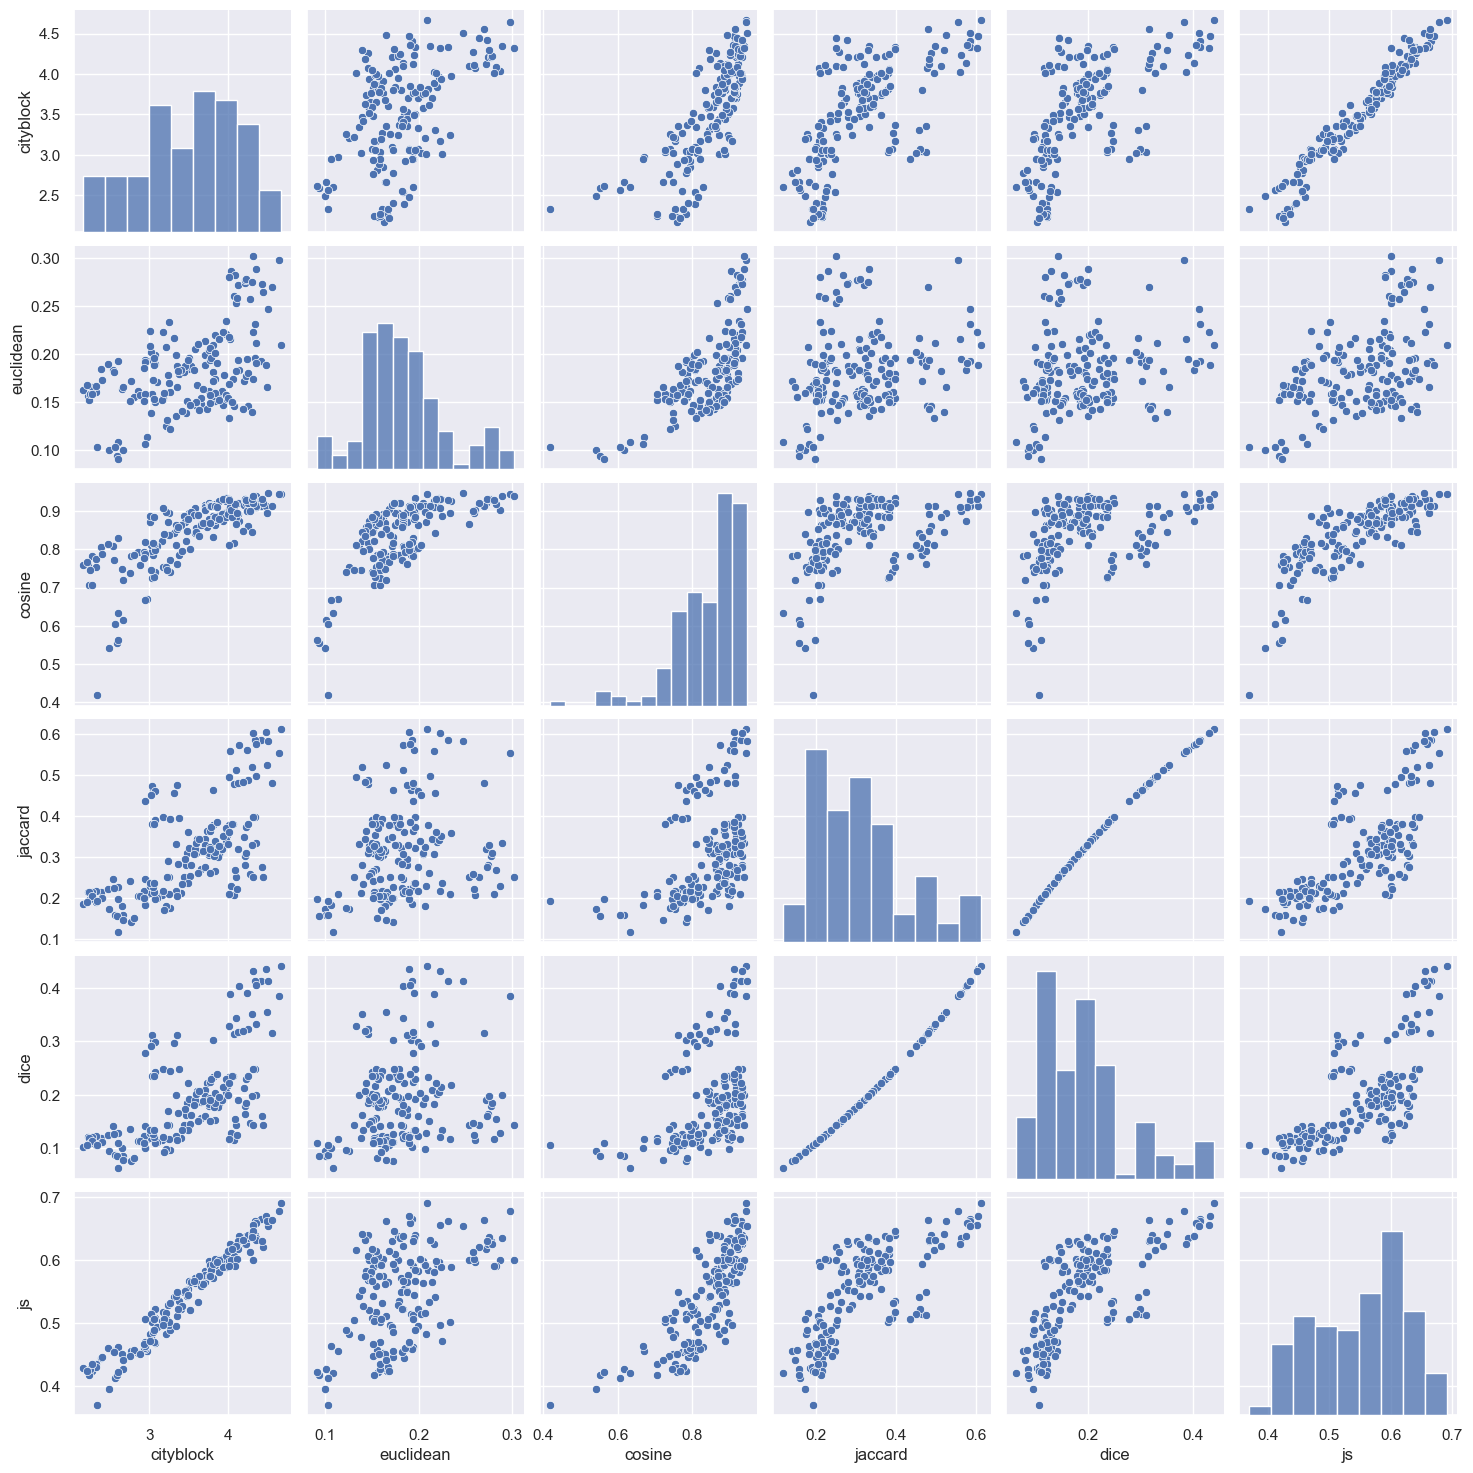

In [28]:
sns.pairplot(SAMPLE);

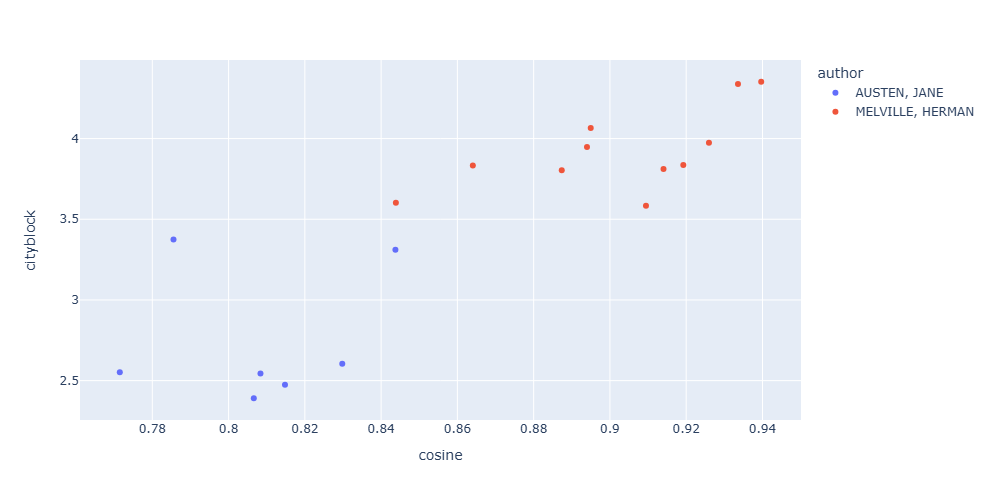

In [29]:
px.scatter(PAIRS.loc[105].join(LIB), 'cosine', 'cityblock', color='author', hover_name='label', width=650, height=500)

In [30]:
PAIRS.sort_values('cosine').head(20).style.background_gradient(colors)

# Create Clusters

We now use our pair-wise distances between books to apply aggomerative clustering.

We visualize the clustering using a dendrogram. 

## Hiearchical

In [31]:
def hac(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 10)):

    # Generate the clustering
    tree = sch.linkage(sims, method=linkage_method)
    
    # Get labels for the leaves
    labels = LIB.label.values
    
    # Create a figure 
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    
    # Create a dendrogram with the tree
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    
    # Change the appearance of ticks, tick labels, and gridlines
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 640x480 with 0 Axes>

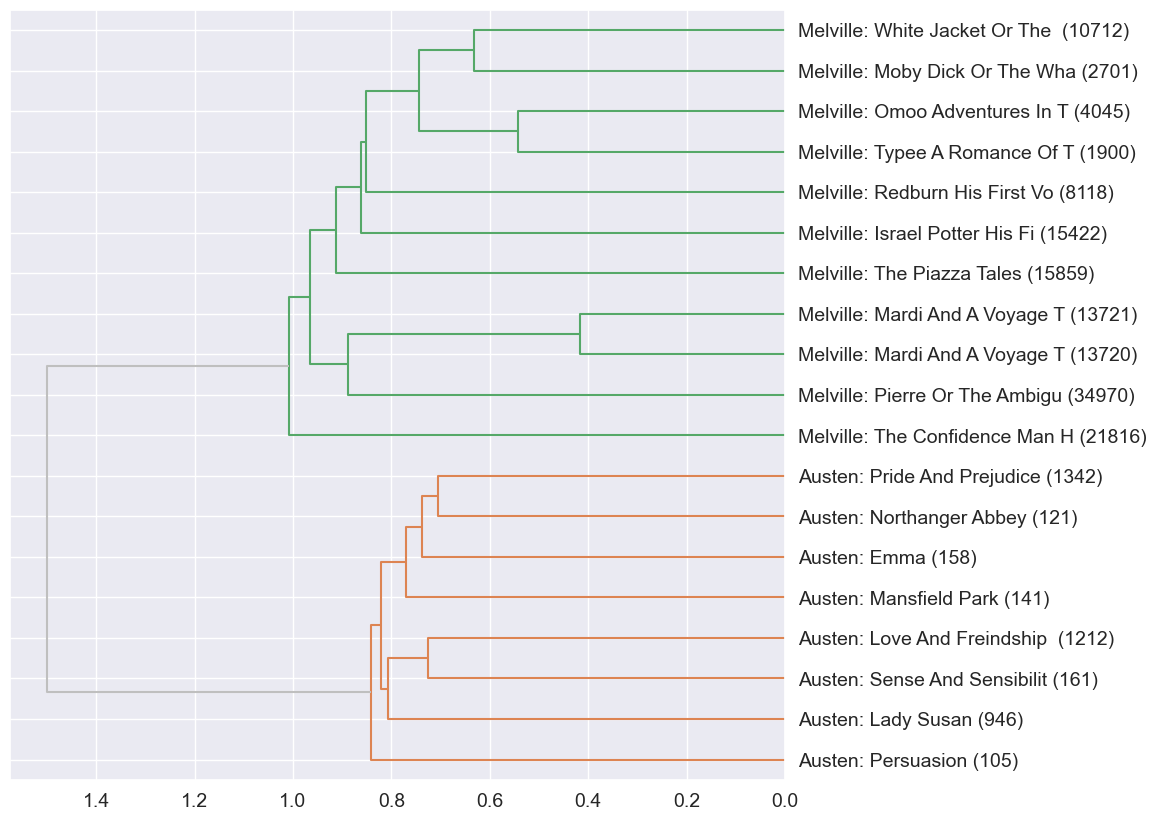

In [32]:
hac(PAIRS.cosine, linkage_method='ward', color_thresh=1.2)

<Figure size 640x480 with 0 Axes>

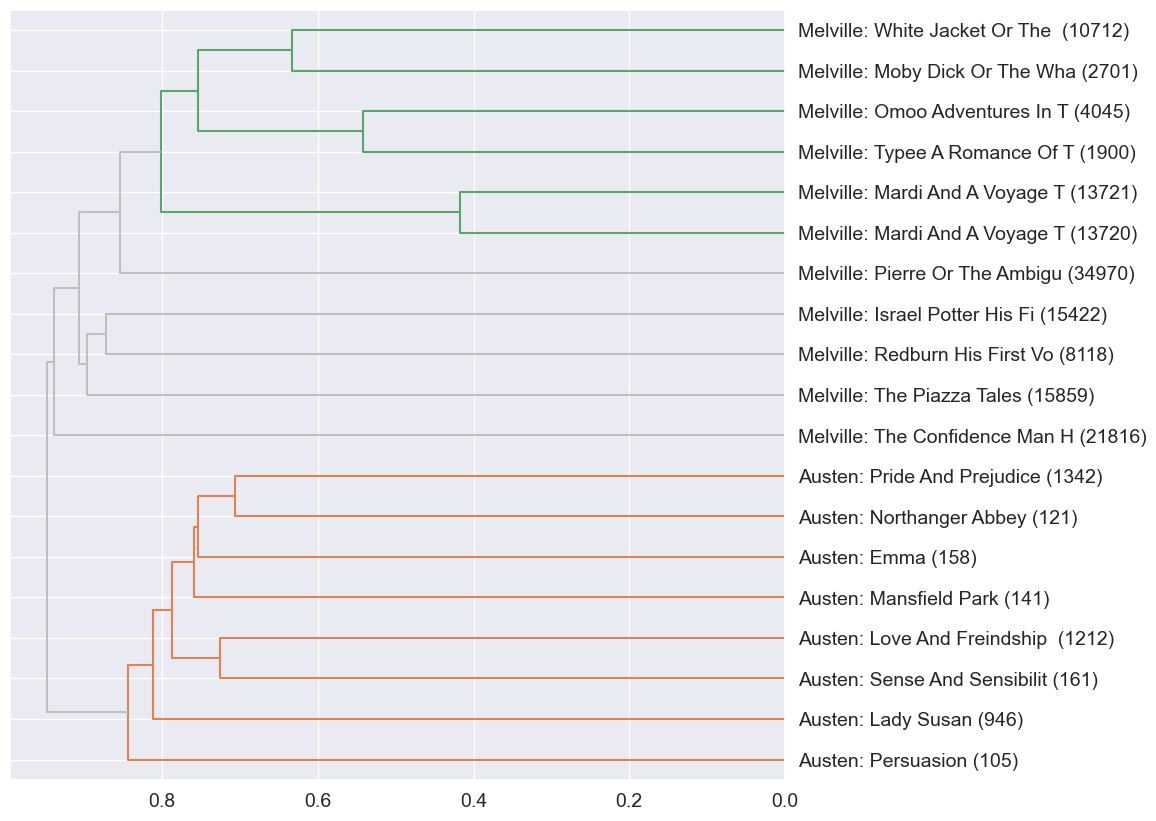

In [33]:
hac(PAIRS.cosine, linkage_method='complete', color_thresh=.85);

<Figure size 640x480 with 0 Axes>

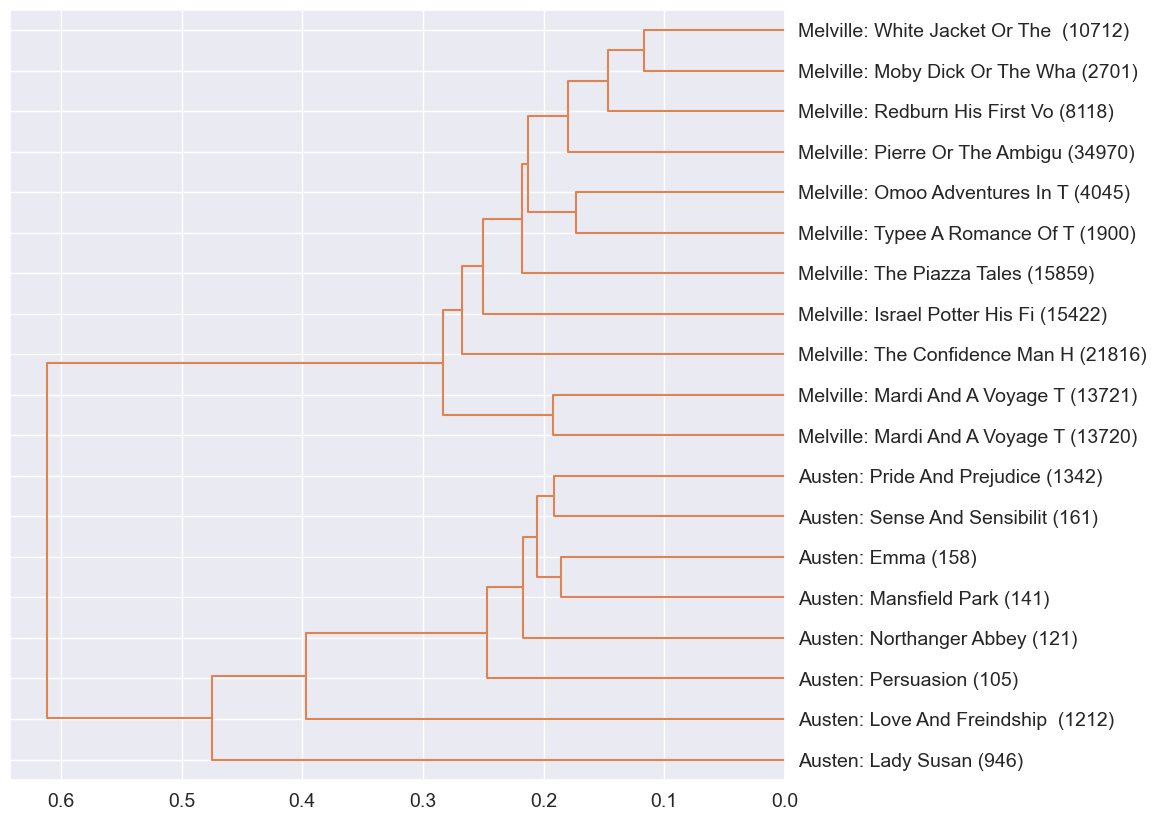

In [34]:
hac(PAIRS.jaccard, color_thresh=.8);

<Figure size 640x480 with 0 Axes>

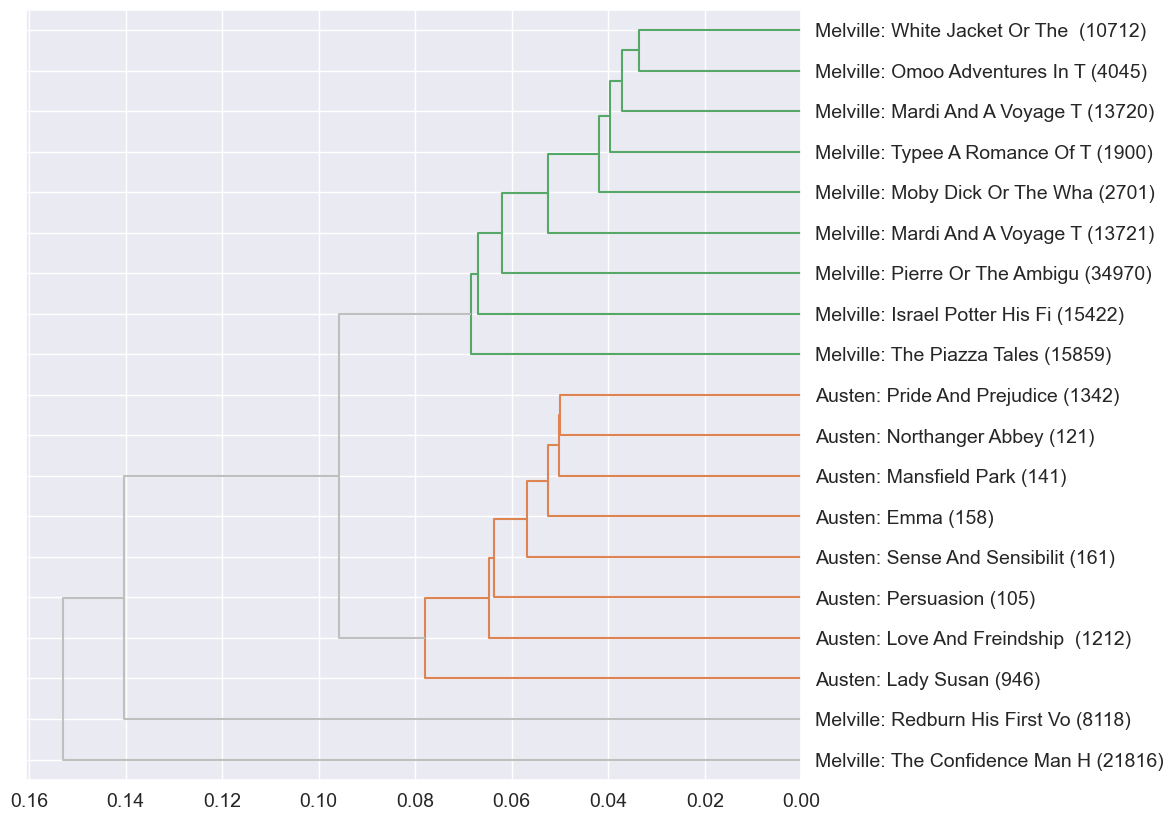

In [34]:
hac(PAIRS.euclidean, linkage_method='ward', color_thresh=.08);

<Figure size 640x480 with 0 Axes>

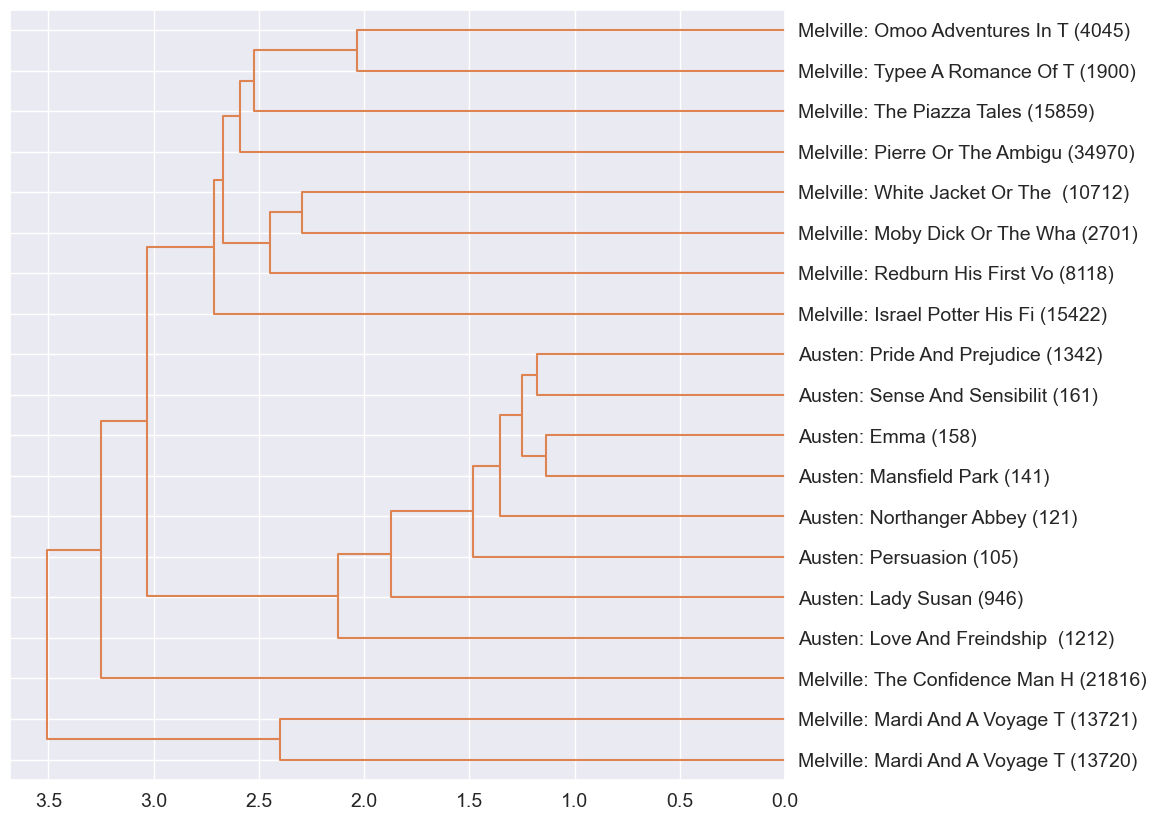

In [35]:
hac(PAIRS.cityblock, color_thresh=1300);

<Figure size 640x480 with 0 Axes>

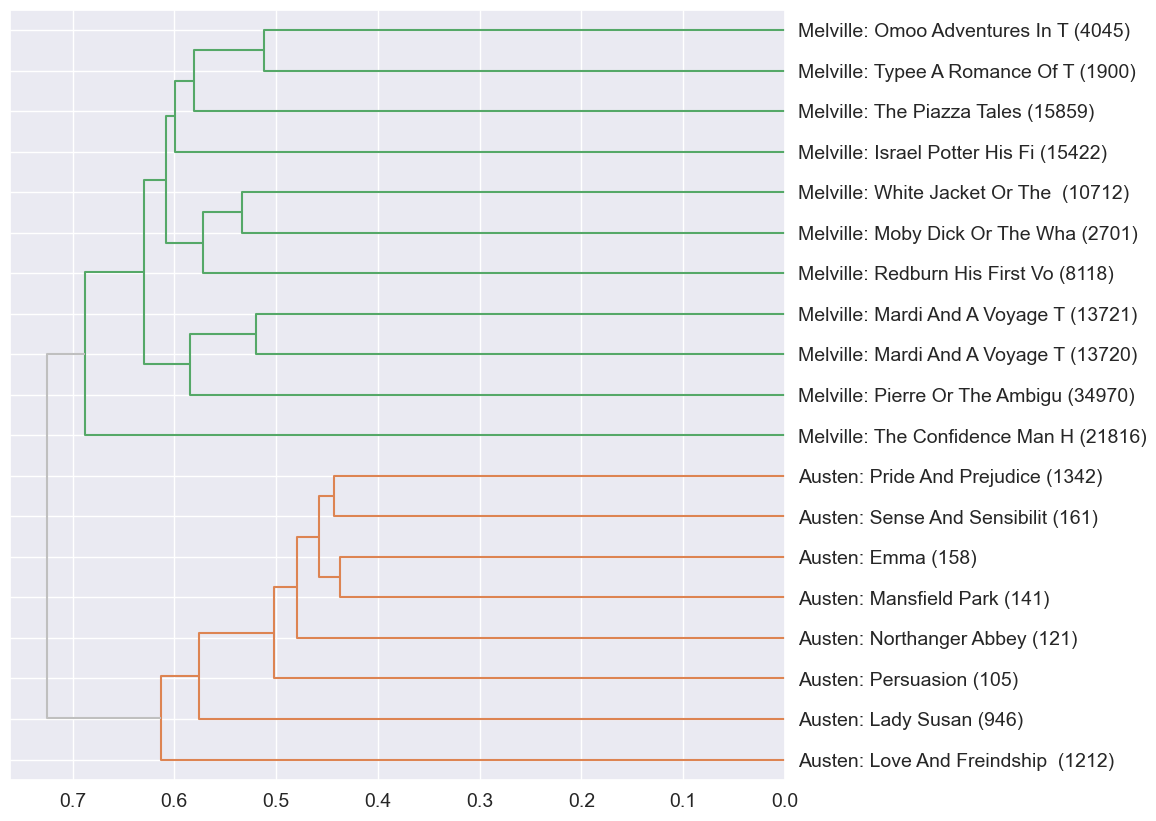

In [36]:
hac(PAIRS.js, color_thresh=.7);

## Questions

What distance measures produce the best results?

## K-Means

K-Means *only* uses Euclidean distance. Why?

* The K-Means procedure does not explicitly use pairwise distances between data points. 
* Instead, it repeatedly assigns points to the closest centroid thereby using Euclidean distance from data points to a centroid. 
* However, K-Means is *implicitly* based on pairwise Euclidean distances between data points, because the sum of squared deviations from centroid is equal to the sum of pairwise squared Euclidean distances divided by the number of points. 
* The term "centroid" is itself from Euclidean geometry. It is multivariate mean in Euclidean space. Euclidean space is about euclidean distances. Non-Euclidean distances will generally not span Euclidean space. That's why K-Means is for Euclidean distances only.

See the [Cross Validated](https://stats.stackexchange.com/questions/81481/why-does-k-means-clustering-algorithm-use-only-euclidean-distance-metric) post on this.

In [37]:
from sklearn.cluster import KMeans

In [38]:
# KMeans?

In [39]:
def get_k_clusters(k=10, n_init='auto'):
    LIB[f'y_raw_{k}'] = KMeans(k, n_init=n_init).fit_predict(TFIDF)
    LIB[f'y_L0_{k}']  = KMeans(k, n_init=n_init).fit_predict(L0)
    LIB[f'y_L1_{k}']  = KMeans(k, n_init=n_init).fit_predict(L1)
    LIB[f'y_L2_{k}']  = KMeans(k, n_init=n_init).fit_predict(L2)
    y_cols = [col for col in LIB.columns if 'y_' in col and f'_{k}' in col]
    return LIB.reset_index().set_index('label')[y_cols].sort_values('label').style.background_gradient(colors)

In [40]:
get_k_clusters(2)

In [41]:
get_k_clusters(4)

# Correlation

Use Pandas' `df.corr('kendall')` method to generate pairs. 

Correlation is normalized covariance, which is the dot product two vectors.

Kendall’s correlation is non-parametric -- it does not require the two variables have a bell curve distribution.

In [42]:
# corr_type = 'pearson'
corr_type = 'kendall'
# corr_type = 'spearman'

In [43]:
CORR_MATRIX = TFIDF.T.corr(corr_type)

## Compare Correlations by Author

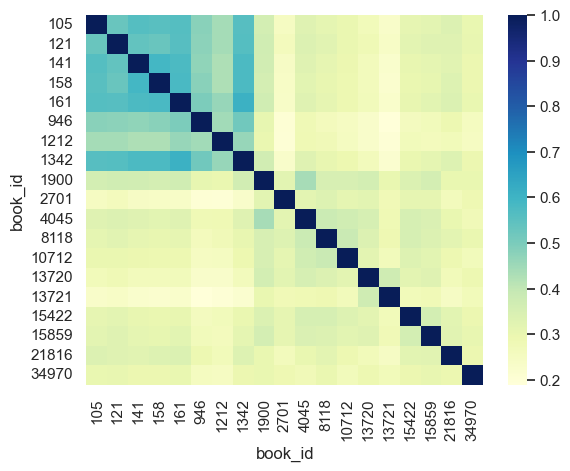

In [44]:
sns.heatmap(CORR_MATRIX, cmap=colors);

In [45]:
# (CORR_MATRIX * 10).astype('int').style.background_gradient(cmap=colors, axis=None)

In [46]:
# SORT = CORR_MATRIX.mean().sort_values(ascending=False).index

In [47]:
# (CORR_MATRIX.loc[SORT, SORT] * 10).astype('int').style.background_gradient(cmap=colors, axis=None)

Find books that have the greatest correlations.

In [48]:
LIB['kendall_sum'] = CORR_MATRIX.sum() - 1

In [49]:
# LIB

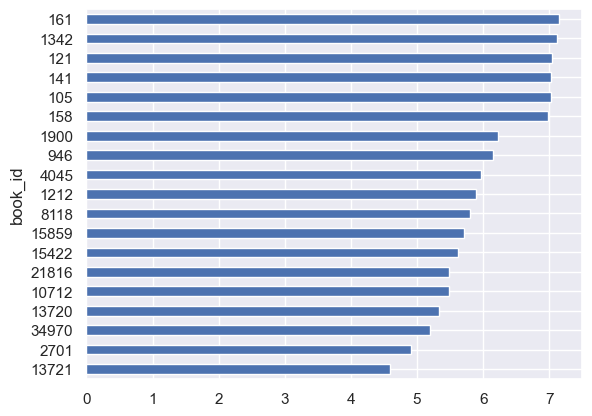

In [50]:
LIB.kendall_sum.sort_values().plot.barh();

# Compare correlation sum to book length

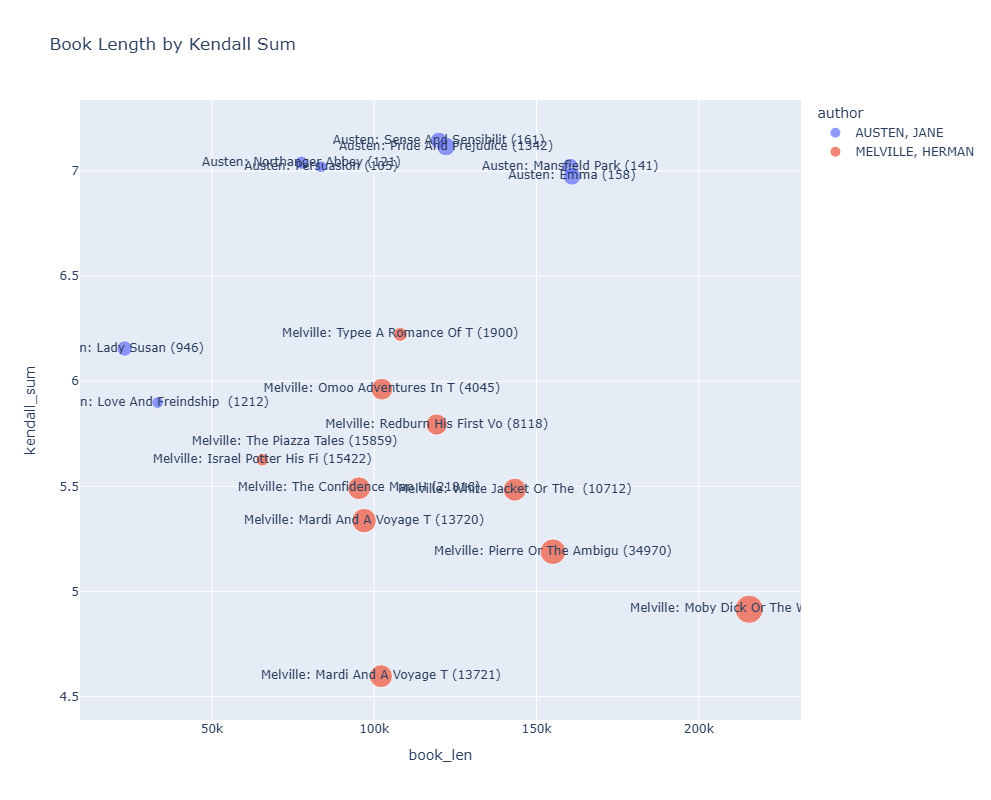

In [51]:
px.scatter(LIB.dropna(), 'book_len', 'kendall_sum', text='label', 
           height=800, width=950, 
           size="n_chaps", color="author", 
           title="Book Length by Kendall Sum")

In [52]:
# ax = LIB.plot.scatter('book_len', 'kendall_sum', figsize=(15,15), title="Book Length by Kendall Sum")
# # Apply labels to plot
# LIB.apply(lambda row: ax.text(row.book_len, row.kendall_sum, f"  {row.label.title()}"), axis=1);

Find out how correlated the works of each author is.

In [53]:
AUS_IDX = LIB[LIB.author.str.contains("AUS")].index.to_list()
MEL_IDX = LIB[LIB.author.str.contains("MEL")].index.to_list()

In [54]:
CM_A = CORR_MATRIX.loc[AUS_IDX, AUS_IDX]
CM_M = CORR_MATRIX.loc[MEL_IDX, MEL_IDX]

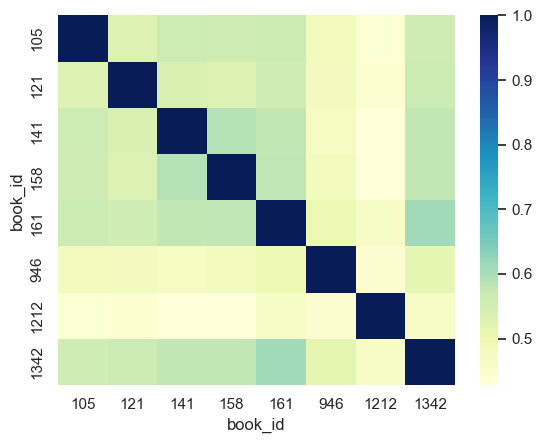

In [55]:
sns.heatmap(CM_A, cmap=colors);

In [56]:
CM_A.mean().mean()

0.5781084070748069

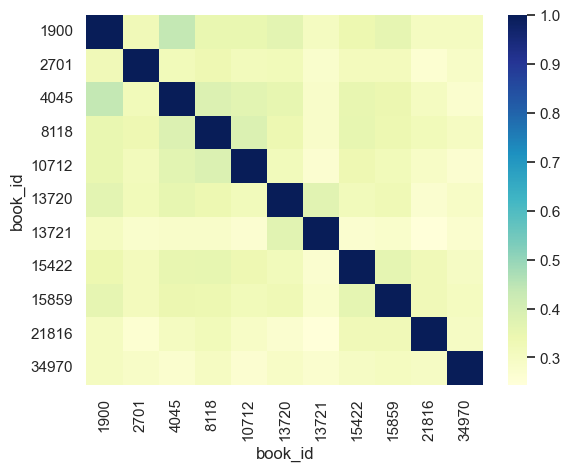

In [57]:
sns.heatmap(CM_M, cmap=colors);

In [58]:
CM_M.mean().mean()

0.3798145292514432

## Hierarchical 

Are correlations good for clustering?

In [59]:
CORR = CORR_MATRIX.stack().to_frame(corr_type).sort_index()
CORR.index.names = ['doc_a', 'doc_b']
CORR = CORR.query('doc_a < doc_b')

<Figure size 640x480 with 0 Axes>

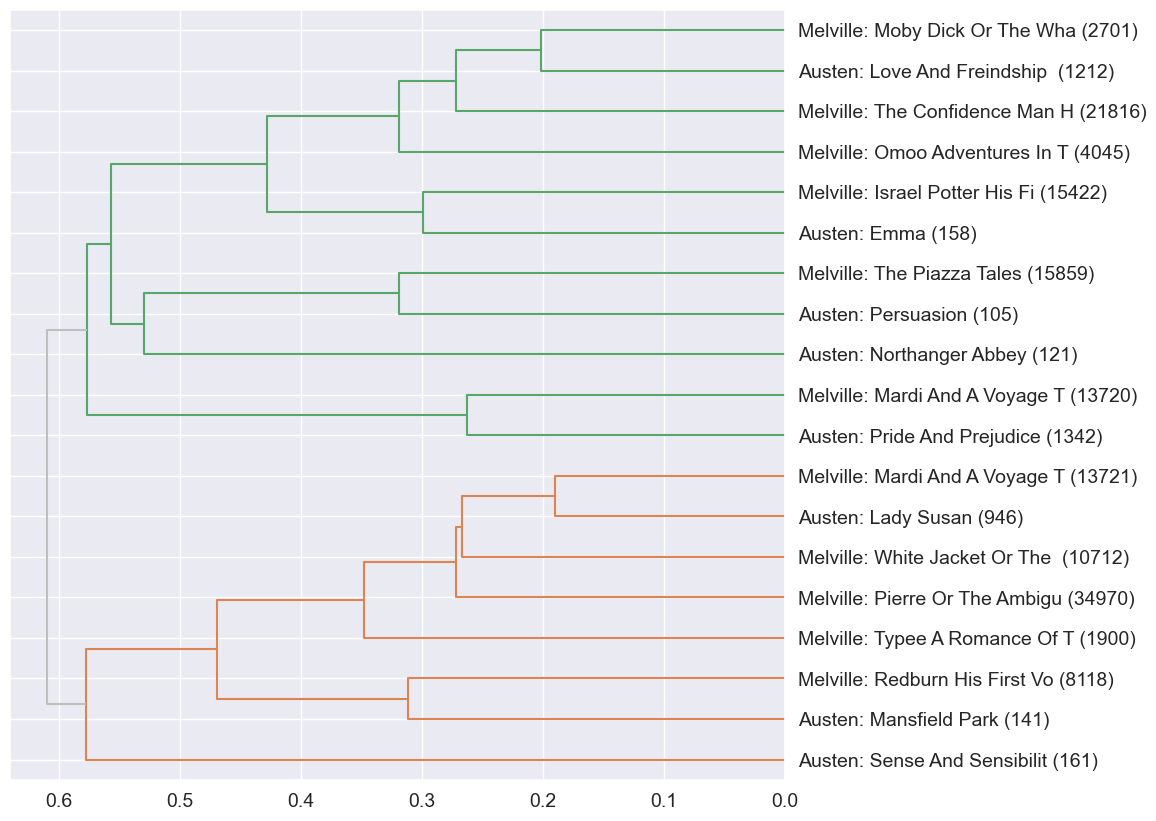

In [60]:
hac(CORR[corr_type], color_thresh=.6);

## Why so bad at clustering?

Correlation is not a distance measure in vector space. 

- It measures the **degree of association** between two variables. 
- It measure the **strength and direction of the relationship** between two variables

So, although both correlation and distance measures concern the relationship between variables, they are fundamentally different concepts and are used for different purposes. 

# Conclusions

* Cosine similarty with Ward Linkage for HAC seems best.
* L2 normalization for K-Means seems best.
* Correlation does not appear useful as a similarity measure for grouping.
* More variance and entropy in Melville compared to Austen.

# Save Work

In [61]:
CORR.join(PAIRS).to_csv(f"{output_dir}/{data_prefix}-DOCPAIRS.csv")
LIB.to_csv(f"{output_dir}/{data_prefix}-LIB_LABELS.csv")